In [0]:
!kill -9 -1

## Install Required Modules

In [1]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 2.8MB/s 


# Connect to Drive

In [2]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


# Add Necessary Directories to Path Variable

In [0]:
import os
import sys
module_path = ('/content/drive/Kaggle/Mask_RCNN-master/', '/content/drive/Kaggle/coco-master/PythonAPI/', '/content/drive/Kaggle/coco-master/PythonAPI/pycocotools/', '/content/drive/Kaggle/Mask_RCNN-master/samples/nucli')
for p in module_path:
  if p not in sys.path:
    sys.path.append(p)

In [0]:
import os
os.environ['PATH'] = os.environ['PATH']+os.path.expanduser((':content/drive/Kaggle/Mask_RCNN-master/:/content/drive/Kaggle/coco-master/PythonAPI/:/content/drive/Kaggle/coco-master/PythonAPI/pycocotools/:/content/drive/Kaggle/Mask_RCNN-master/samples/nucli'))

In [5]:
print(os.environ['PATH'])

/usr/local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:content/drive/Kaggle/Mask_RCNN-master/:/content/drive/Kaggle/coco-master/PythonAPI/:/content/drive/Kaggle/coco-master/PythonAPI/pycocotools/:/content/drive/Kaggle/Mask_RCNN-master/samples/nucli


In [0]:
import os
os.chdir('/content/drive/Kaggle/Mask_RCNN-master/samples/nucli')

In [7]:
!ls ../../

assets	    inspect_data.ipynb	   mask_rcnn_coco.h5  samples
coco.py     inspect_model.ipynb    model.py	      shapes.py
config.py   inspect_weights.ipynb  parallel_model.py  train_shapes.ipynb
demo.ipynb  LICENSE		   __pycache__	      utils.py
images	    logs		   README.md	      visualize.py


# Mask R-CNN - Inspect Nucli Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [8]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = '/content/drive/Kaggle/Mask_RCNN-master/samples/nucli' #os.getcwd()
if ROOT_DIR.endswith("samples/nucli"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

# Import Mask RCNN
sys.path.append(ROOT_DIR)
import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

import nucli

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
NUCLI_WEIGHTS_PATH = "/content/drive/Kaggle/Mask_RCNN-master/samples/nucli/mask_rcnn_nucli_all.h5"  # TODO: update this path
print('ROOT_DIR',ROOT_DIR)

Using TensorFlow backend.


ROOT_DIR /content/drive/Kaggle/Mask_RCNN-master


## Configurations

In [0]:
config = nucli.NucliConfig()
NUCLI_DIR = '/content/drive/Kaggle/datasets/nucli' #os.path.join(ROOT_DIR, "datasets/nucli")

In [10]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nucli
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000


## Notebook Preferences

In [0]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [13]:
# Load validation dataset
dataset_dict = {"train":"stage1_train", "test":"stage1_test", "test2":"stage2_test_final"}
dataset = nucli.NucliDataset(dataset_dict)
dataset.load_nucli(NUCLI_DIR, "test")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

100%|██████████| 65/65 [01:08<00:00,  1.05s/images]

Images: 65
Classes: ['BG', 'nucli']


## Load Model

In [0]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [15]:
# Set path to nucli weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
weights_path = NUCLI_WEIGHTS_PATH

# Or, load the last model you trained
#weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/drive/Kaggle/Mask_RCNN-master/samples/nucli/mask_rcnn_nucli_all.h5


## Run Detection

image ID: nucli.38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990c535d1030637bf6a1f (17) /content/drive/Kaggle/datasets/nucli/stage1_test/38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990c535d1030637bf6a1f
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  160.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   56.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


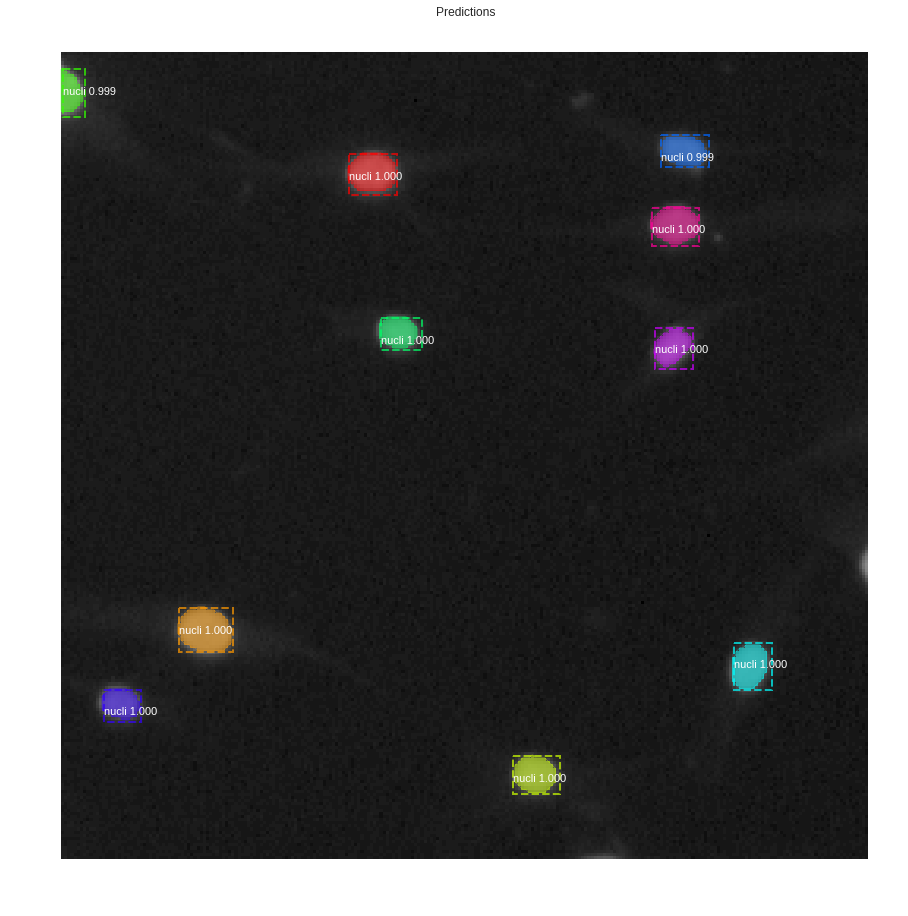

In [16]:
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

## Color Splash

This is for illustration. You can call `nucli.py` with the `splash` option to get better images without the black padding.

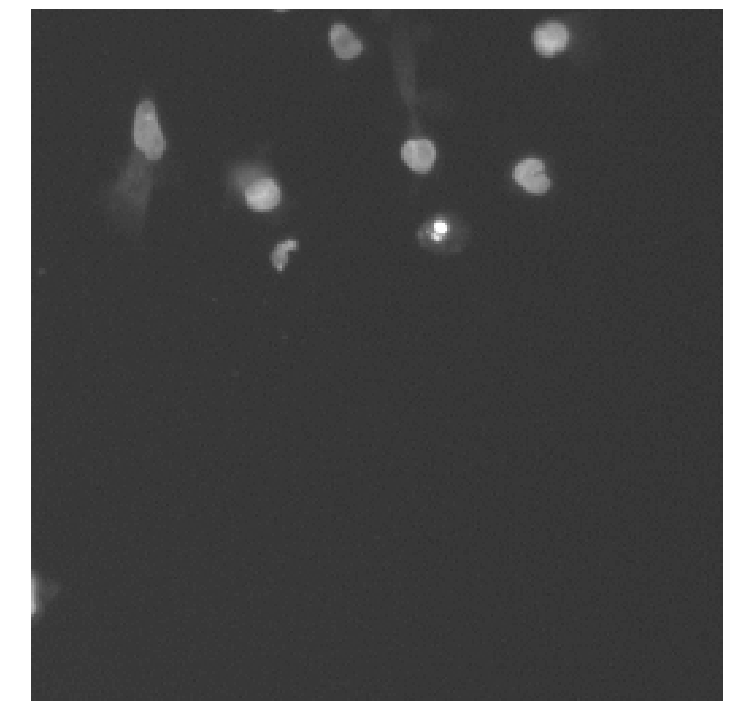

In [37]:
splash = nucli.color_splash(image, r['masks'])
display_images([splash], cols=1)

## Get all Test Predictions

In [17]:
preds_test=np.array([dict() for _ in dataset.image_ids])

for i, image_id in enumerate(dataset.image_ids):
  image = dataset.load_image(image_id)
  info = dataset.image_info[image_id]
  print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

  # Run object detection
  results = model.detect([image], verbose=0)
  preds_test[i]['id']=info["id"]
  preds_test[i]['image']=image
  mask = (np.sum(results[0]["masks"], -1, keepdims=True) >= 1) 
  preds_test[i]['pred']=np.squeeze(mask)
  print(preds_test[i]['pred'].shape)
  
  

image ID: nucli.0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5 (0) /content/drive/Kaggle/datasets/nucli/stage1_test/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


(256, 256)
image ID: nucli.0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732 (1) /content/drive/Kaggle/datasets/nucli/stage1_test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732
(256, 256)
image ID: nucli.0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac (2) /content/drive/Kaggle/datasets/nucli/stage1_test/0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac
(519, 253)
image ID: nucli.0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6 (3) /content/drive/Kaggle/datasets/nucli/stage1_test/0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6
(256, 256)
image ID: nucli.0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925 (4) /content/drive/Kaggle/datasets/nucli/stage1_test/0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925
(256, 256)
image ID: nucli.0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466 (5) /content/drive/Kaggle/datasets/nucli/stage1_test/0f1f896d9ae5a04

(512, 680)
image ID: nucli.f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002b52cf7b496612e0ce4 (59) /content/drive/Kaggle/datasets/nucli/stage1_test/f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002b52cf7b496612e0ce4
(520, 696)
image ID: nucli.dab46d798d29aff2e99c23f47ed3064f5cafb1644629b015c95a2dd2ee593bb4 (60) /content/drive/Kaggle/datasets/nucli/stage1_test/dab46d798d29aff2e99c23f47ed3064f5cafb1644629b015c95a2dd2ee593bb4
(256, 256)
image ID: nucli.e17b7aedd251a016c01ef9158e6e4aa940d9f1b35942d86028dc1222192a9258 (61) /content/drive/Kaggle/datasets/nucli/stage1_test/e17b7aedd251a016c01ef9158e6e4aa940d9f1b35942d86028dc1222192a9258
(256, 256)
image ID: nucli.df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8 (62) /content/drive/Kaggle/datasets/nucli/stage1_test/df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8
(260, 347)
image ID: nucli.fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e1751a9d412a14ab5e3 (63) /content/drive/Kaggle/datasets/nucli/stage1_test/fac507fa4d

In [0]:
np.save('preds_test', preds_test)

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

## Step by Step Prediction

In [0]:
from skimage.morphology import label
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [27]:
new_test_ids = []
rles = []
for n, id_ in enumerate(dataset.image_ids):
    print("shape:", n, preds_test[n]["pred"].shape, preds_test[n]["image"].shape)
    #imshow((X_test[n]*tstd+tmean)*255)
    #plt.show()
    #imshow(preds_test_upsampled[n])
    #plt.show()
    rle = list(prob_to_rles(preds_test[n]["pred"]))
    rles.extend(rle)
    new_test_ids.extend([preds_test[n]["id"]] * len(rle))

shape: 0 (256, 256) (256, 256, 3)
shape: 1 (256, 256) (256, 256, 3)
shape: 2 (512, 680) (512, 680, 3)
shape: 3 (512, 680) (512, 680, 3)
shape: 4 (256, 256) (256, 256, 3)
shape: 5 (256, 256) (256, 256, 3)
shape: 6 (519, 253) (519, 253, 3)
shape: 7 (512, 640) (512, 640, 3)
shape: 8 (256, 256) (256, 256, 3)
shape: 9 (512, 640) (512, 640, 3)
shape: 10 (519, 162) (519, 162, 3)
shape: 11 (256, 256) (256, 256, 3)
shape: 12 (512, 680) (512, 680, 3)
shape: 13 (512, 640) (512, 640, 3)
shape: 14 (524, 348) (524, 348, 3)
shape: 15 (256, 256) (256, 256, 3)
shape: 16 (256, 256) (256, 256, 3)
shape: 17 (519, 253) (519, 253, 3)
shape: 18 (520, 348) (520, 348, 3)
shape: 19 (256, 256) (256, 256, 3)
shape: 20 (524, 348) (524, 348, 3)
shape: 21 (260, 347) (260, 347, 3)
shape: 22 (256, 256) (256, 256, 3)
shape: 23 (512, 680) (512, 680, 3)
shape: 24 (512, 640) (512, 640, 3)
shape: 25 (512, 680) (512, 680, 3)
shape: 26 (256, 256) (256, 256, 3)
shape: 27 (390, 239) (390, 239, 3)
shape: 28 (260, 347) (260, 347

... and then finally create our submission!

In [87]:
print(rles[1])

[50280, 6, 50533, 11, 50788, 13, 51043, 14, 51298, 15, 51553, 16, 51809, 16, 52064, 17, 52320, 17, 52576, 17, 52832, 16, 53089, 15, 53346, 13, 53602, 11, 53860, 8]


In [0]:
from google.colab import files
import pandas as pd
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018_mask_rcnn_test2.csv', index=False)
files.download('sub-dsbowl2018_mask_rcnn_test2.csv')

In [0]:
!ls

datalab   model-dsbowl2018-unet2.h5  nucli2.zip  sub-dsbowl2018.csv
__MACOSX  nucli			     nucli.zip	 zf_unet_256.h5


In [0]:
files.download('zf_unet_224.h5')

In [0]:
from google.colab import files
files.download('model-dsbowl2018-unet2.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 56556, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

MessageError: ignored

This scored 0.233 on the LB for me. That was with version 2 of this notebook; be aware that the results from the neural network are extremely erratic and vary greatly from run to run (version 3 is significantly worse, for example). Version 7 scores 0.277!

You should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

**Have fun!**

LB score history:
- Version 7: 0.277 LB

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [0]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (256, 4)              min:   -1.25000  max:    1.59227
positive_anchors         shape: (13, 4)               min:  160.00000  max:  624.00000
negative_anchors         shape: (243, 4)              min:  -45.25483  max: 1082.50967
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867
refined_anchors          shape: (13, 4)               min:  154.00000  max:  613.00000


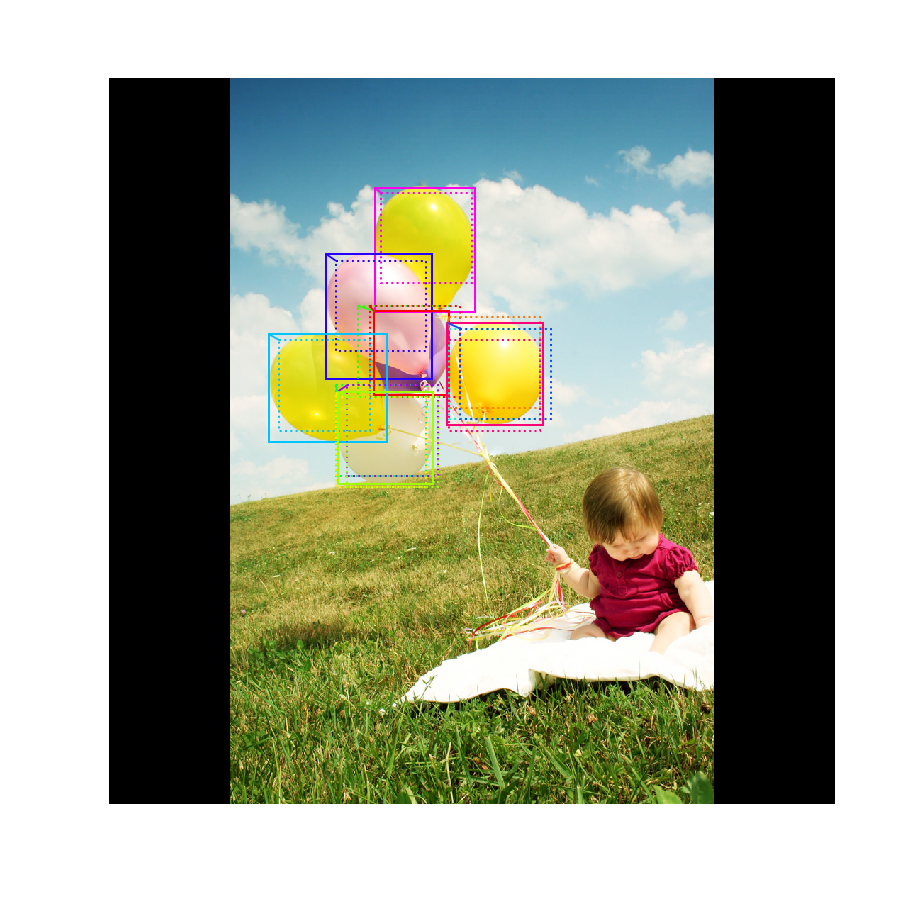

In [0]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [0]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 6000, 4)          min: -362.03867  max: 1322.03870
refined_anchors          shape: (1, 6000, 4)          min: -54523.60547  max: 55483.12109
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max: 1024.00000
post_nms_anchor_ix       shape: (799,)                min:    0.00000  max: 5982.00000
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


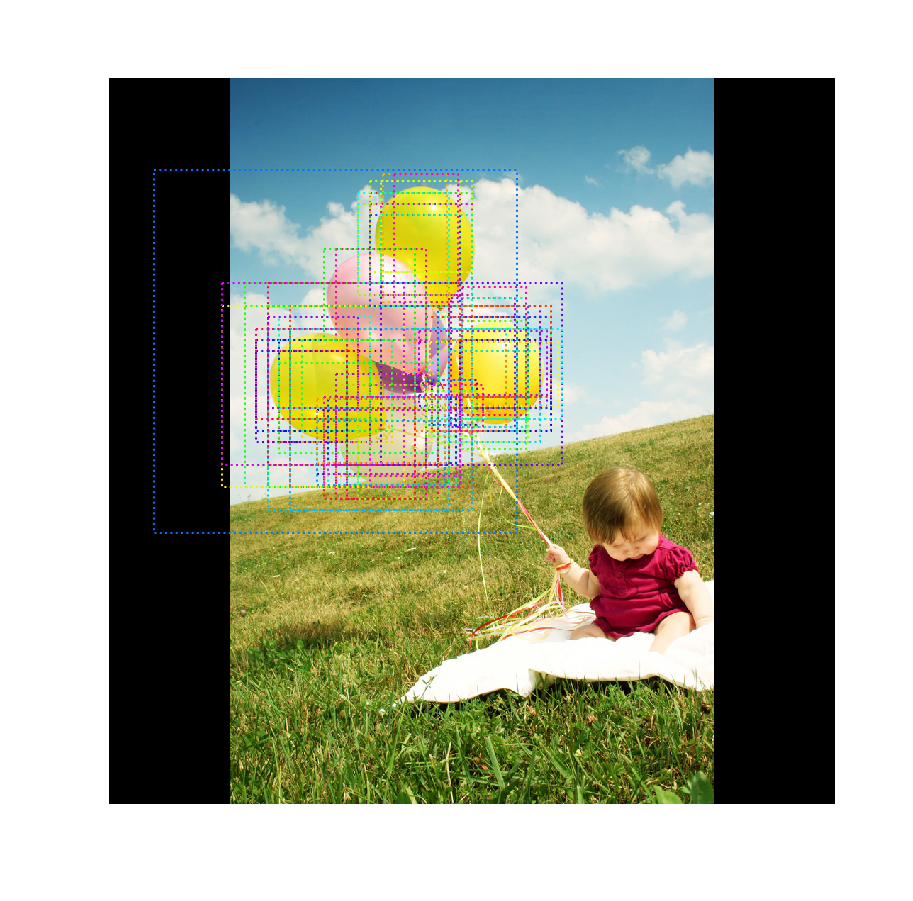

In [0]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

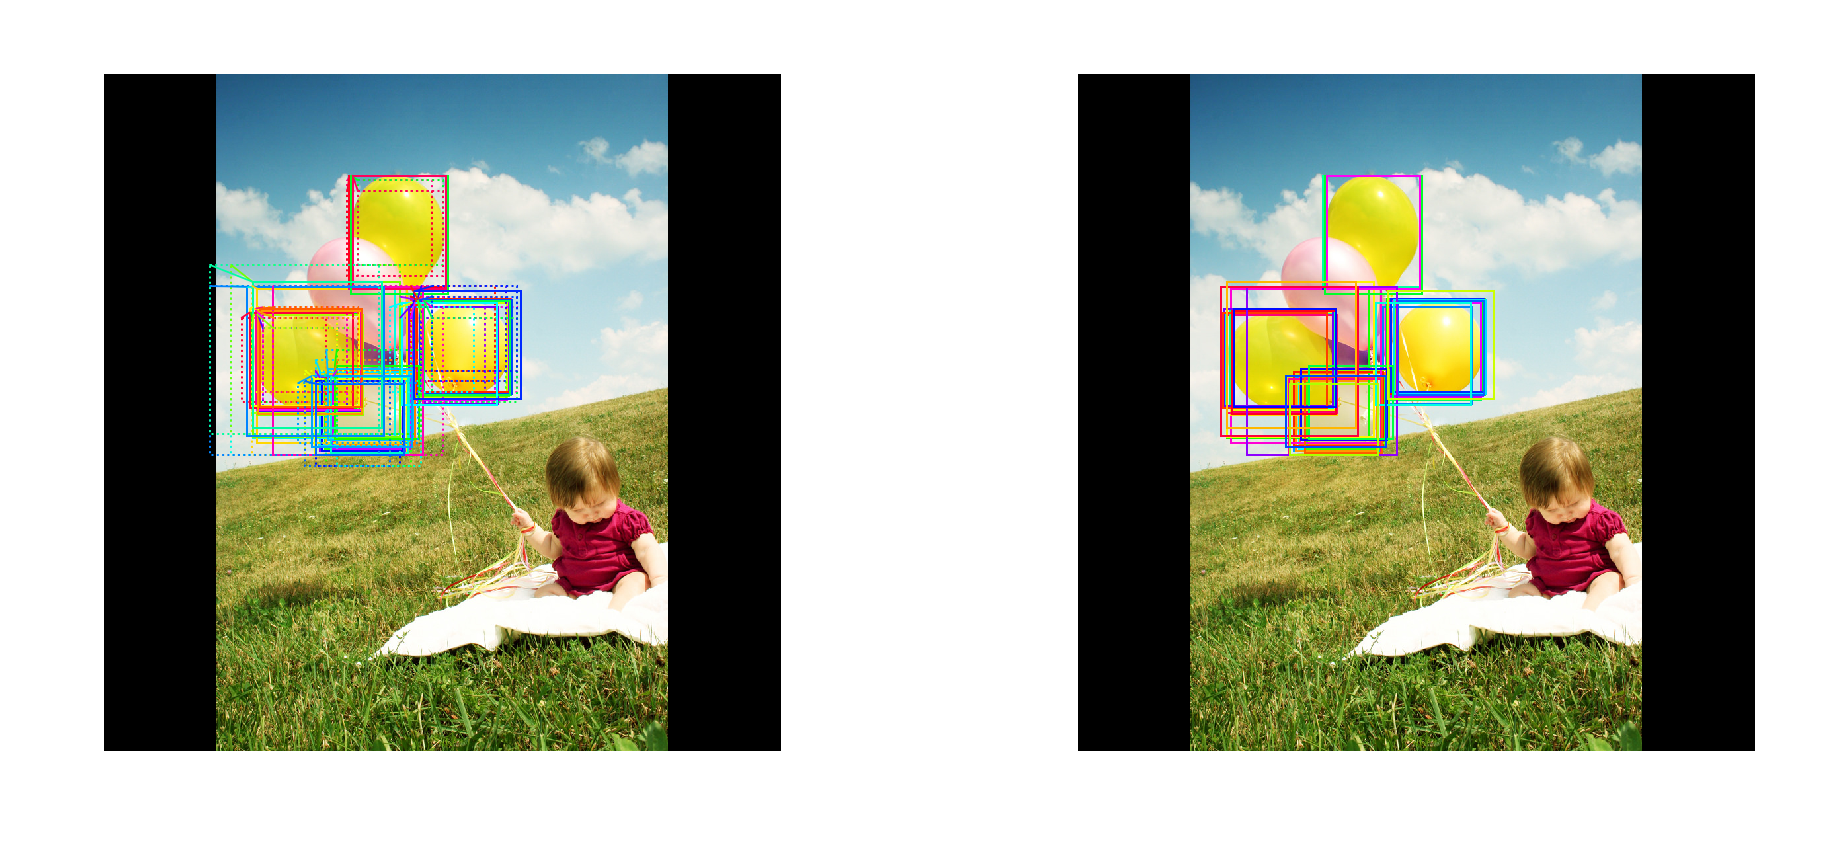

In [0]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

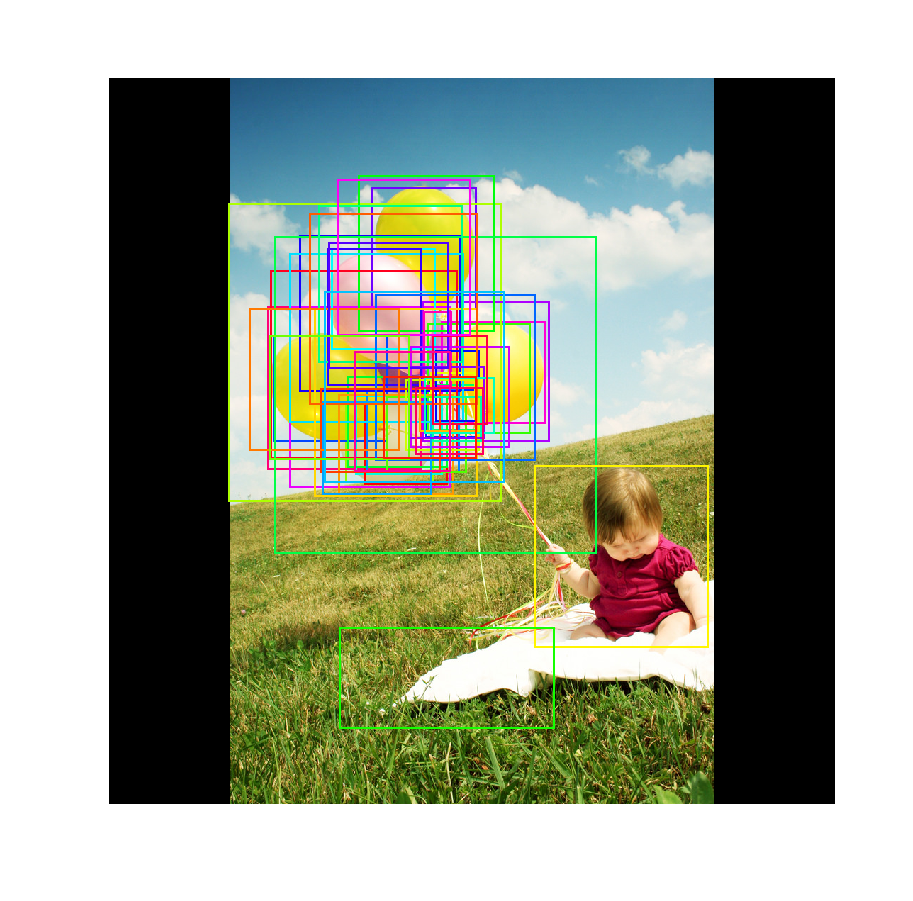

In [0]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

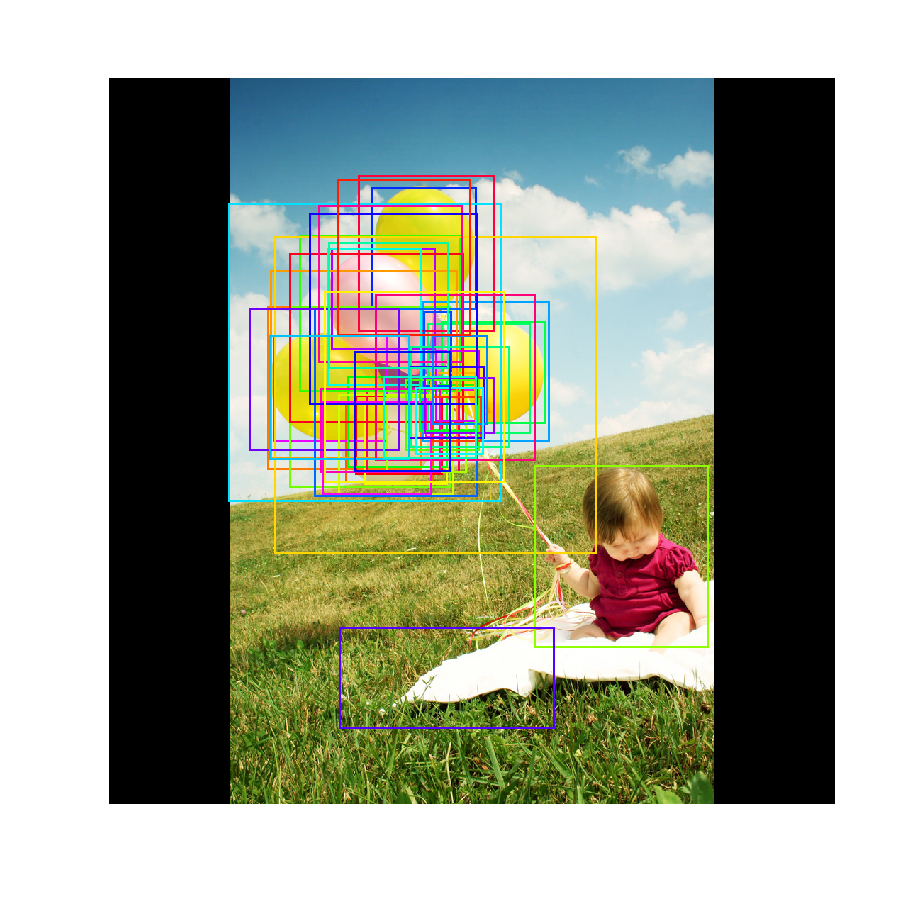

In [0]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [0]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000
deltas                   shape: (1, 1000, 2, 4)       min:   -4.37868  max:    5.65765
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000
detections               shape: (1, 100, 6)           min:    0.00000  max:  616.00000


5 detections: ['balloon' 'balloon' 'balloon' 'balloon' 'balloon']


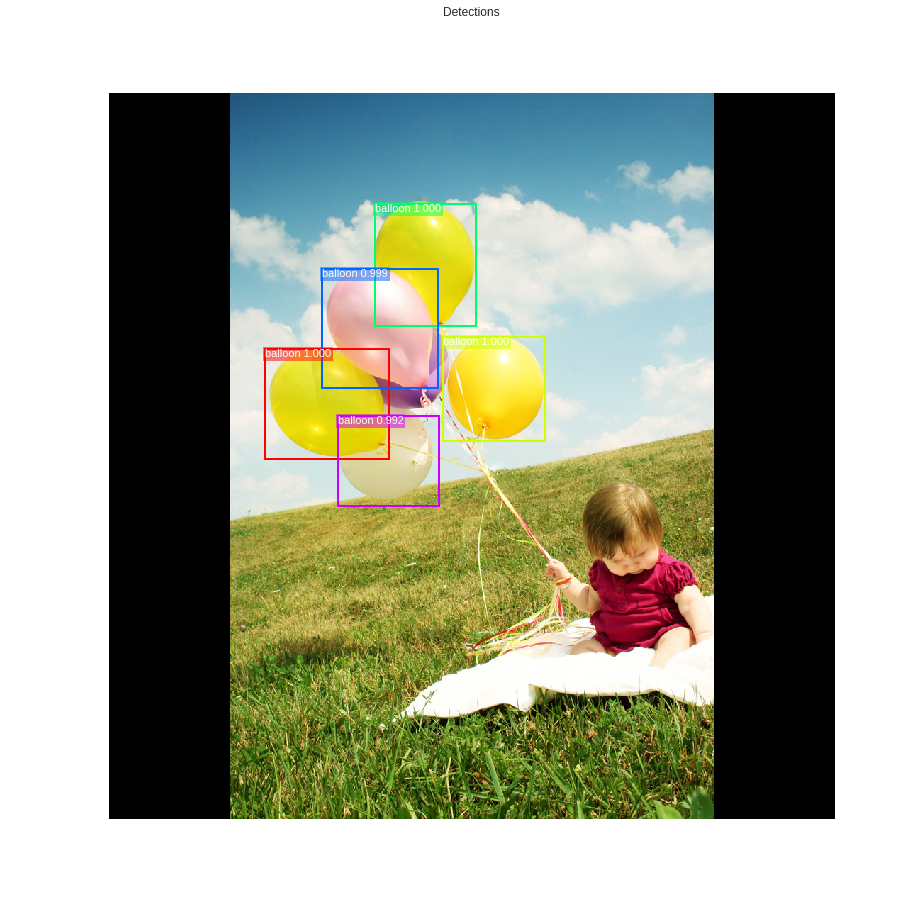

In [0]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=detections[:, :4],
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [0]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

799 Valid proposals out of 1000
45 Positive ROIs
[('BG', 955), ('balloon', 45)]


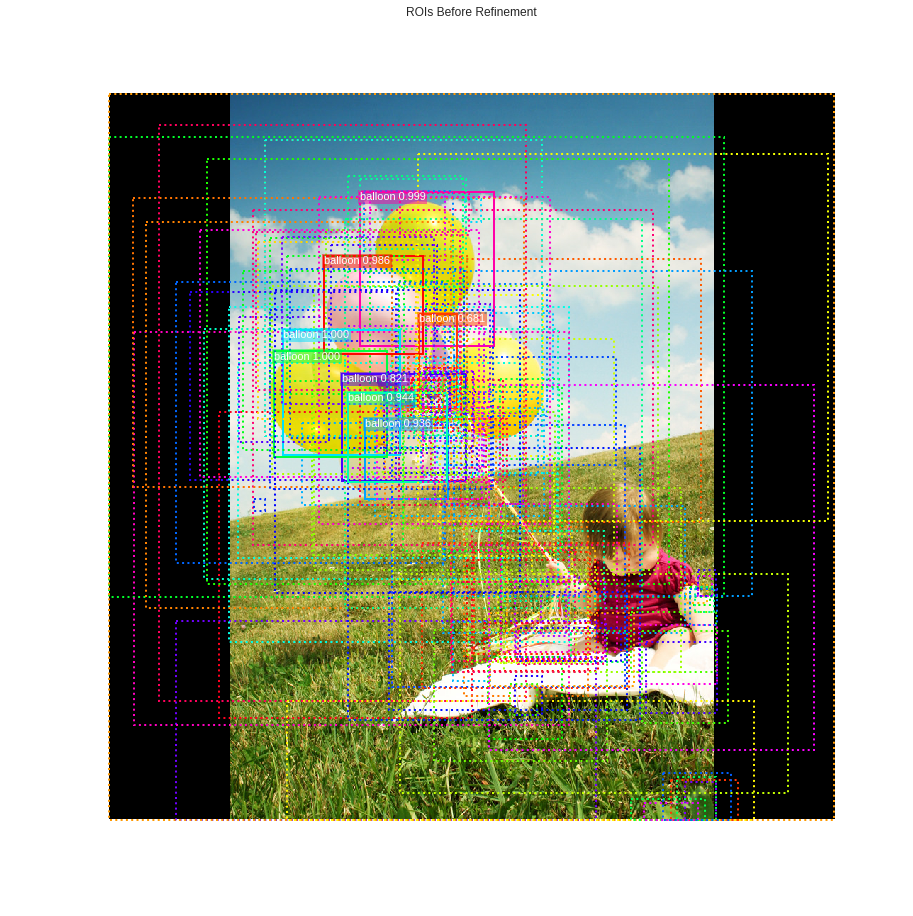

In [0]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -4.37868  max:    5.65765
refined_proposals        shape: (1000, 4)             min: -209.00000  max: 1242.00000


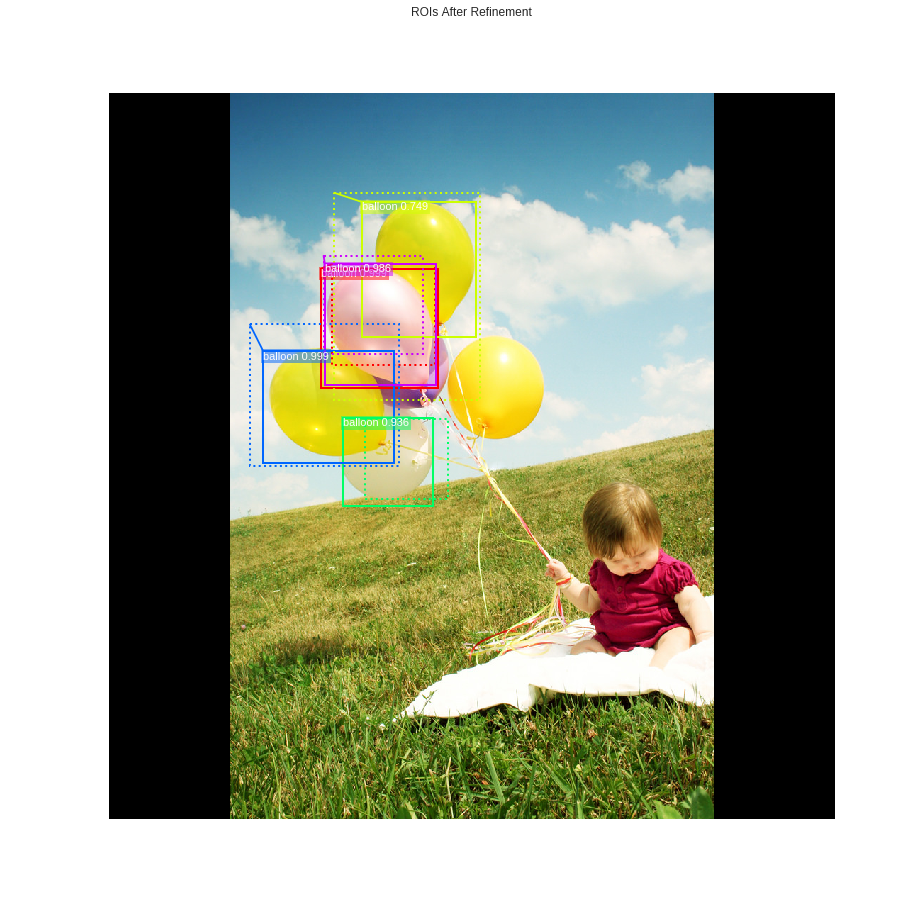

In [0]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [0]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 45 detections:
[  0   1   2   3   4   5   7   9  11  13  14  15  18  22  23  32  35  39
  41  43  45  49  50  55  61  69  72  73  74  77  84  85  91 100 113 114
 115 148 155 183 229 256 371 375 439]


In [0]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 34:
[  0   1   2   3   4   5   7   9  11  13  14  15  22  23  32  35  39  41
  43  45  50  69  72  73  77  84  85 113 114 148 183 229 371 439]


#### Per-Class Non-Max Suppression

In [0]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

balloon               : [  0   1   2   3   4   5   7   9  11  13  14  15  22  23  32  35  39  41
  43  45  50  69  72  73  77  84  85 113 114 148 183 229 371 439] -> [ 5  4  0 13 35]

Kept after per-class NMS: 5
[ 0  4  5 13 35]


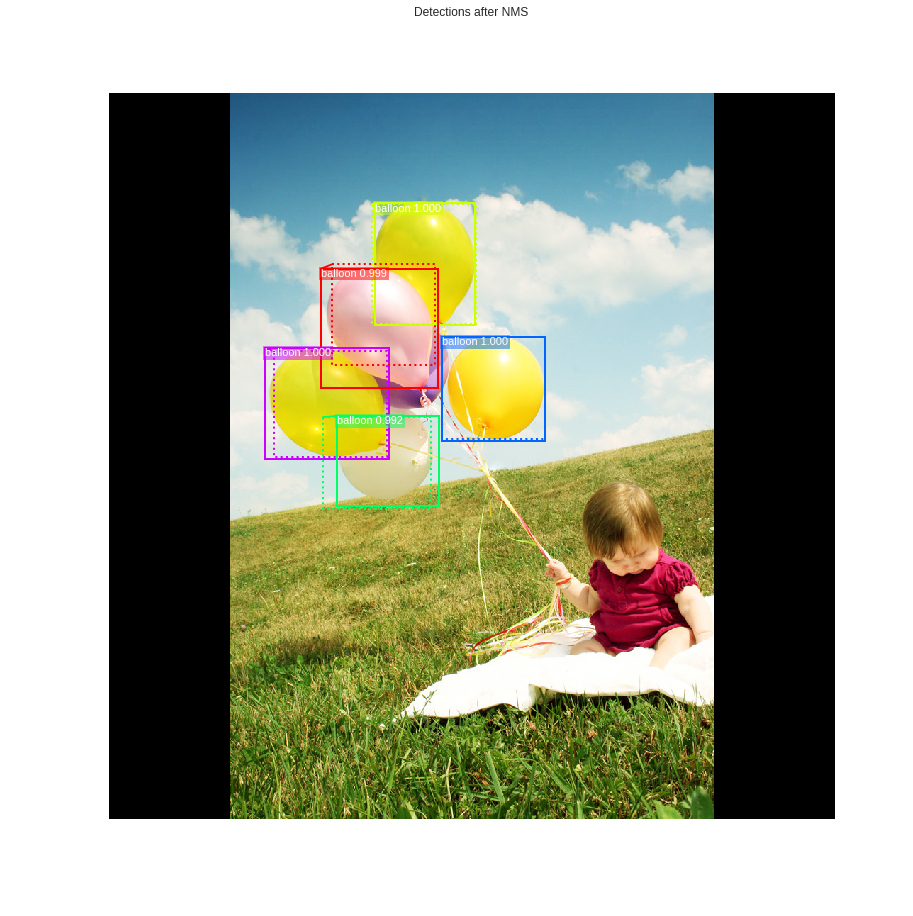

In [0]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

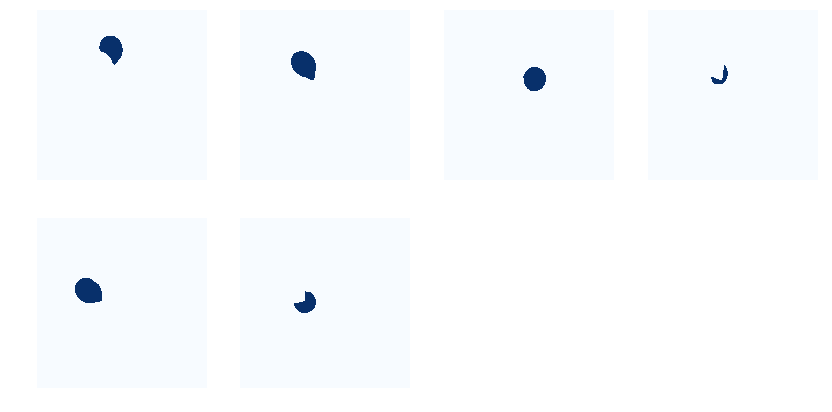

In [0]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [0]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:  616.00000
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000
5 detections: ['balloon' 'balloon' 'balloon' 'balloon' 'balloon']


In [0]:
# Masks
det_boxes = mrcnn["detections"][0, :, :4].astype(np.int32)
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (5, 28, 28)           min:    0.00000  max:    1.00000
det_masks                shape: (5, 1024, 1024)       min:    0.00000  max:    1.00000


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


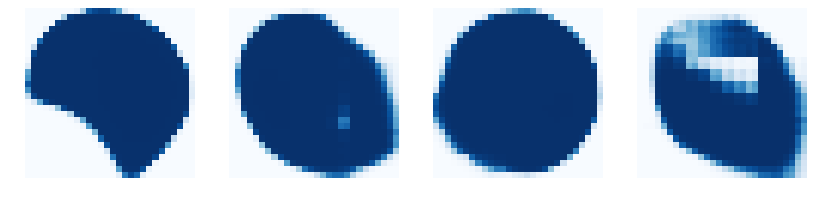

In [0]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

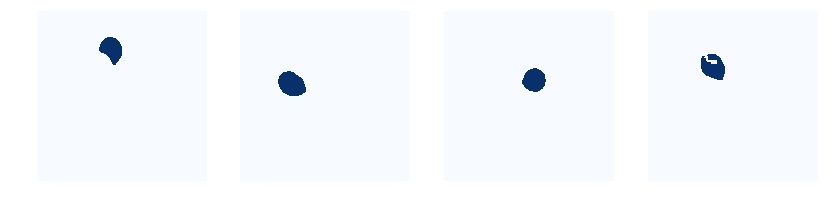

In [0]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [0]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   31.50939
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   29.30352
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   60.03770
rpn_bbox                 shape: (1, 261888, 4)        min:   -8.80906  max:  101.67661
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


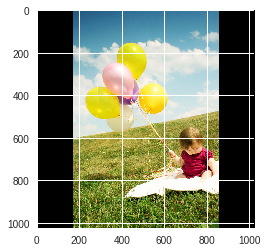

In [0]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

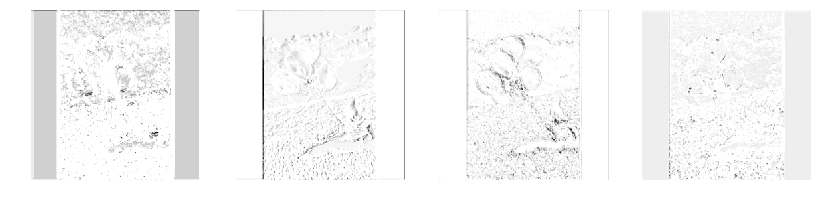

In [0]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)